# Deep Learning - Assigment 1

### Group Number: 22

### Teammates:
1. **Mahshid Jafar Tajrishi**
2. **Bar Melinarskiy**
3. **Cis van Aken**
4. **Simon van Klompenburg**

## Imports entire notebook

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
from scipy.io import loadmat
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
torch.autograd.set_detect_anomaly(True)
from copy import deepcopy as dc
import random
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy.interpolate import interp1d

## Global Definitions

In [2]:
# Path to the zip file
data_dir = "./Data"
data_path = f"{data_dir}/Xtrain.mat"
output_dir = "./Output"
model_dir = "./Models"

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)

# Set a professional style for the plots
sns.set_theme(style="whitegrid")

model_name = "RNN"
model_pth_path = f"{model_dir}/best_model_{model_name}.pth"
random.seed(42)

In [3]:
# Check if CUDA is available
print(torch.__version__)
print(torch.version.cuda)  # Should match CUDA 12.5
print(torch.backends.cudnn.version())  # Should return a version, not None
print(torch.cuda.is_available())  # Should return True

2.5.1
None
90100
True


### Utilities 

In [4]:
def create_sequences(data, window_size, forecast_steps=1):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_steps + 1):
        X.append(data[i:i + window_size, 0])
        y.append(data[i + window_size:i + window_size + forecast_steps, 0])
    X = np.array(X).reshape(-1, window_size, 1)
    y = np.array(y).reshape(-1, forecast_steps)
    return X, y

def prepare_dataloader(series, window_size, batch_size=16):
    """
    Preprocess the datasets for the transformer model.

    Args:
        series: Array of numbers with the sequence of the laser measurements.
        window_size: Integer, the sliding window size.
        batch_size: The number of samples used in one forward and backward pass through the network.

    Returns:
        DataLoader, X, y
    """
    X, y = create_sequences(series, window_size)
    # Ensure proper shapes: X → (N, seq_len, input_dim), y → (N, input_dim)
    X_tensor = torch.tensor(X, dtype=torch.float32)  # Shape: (N, seq_len, input_dim)
    y_tensor = torch.tensor(y, dtype=torch.float32)  # Shape: (N, input_dim)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False), X_tensor, y_tensor

def train_model(model, train_loader, val_loader, attempt_index, epochs=20, lr=1e-3, teacher_forcing_prob=0.5, patience=10):
    """
    Train the given model with validation and return the final validation L1 loss.
    Includes early stopping based on validation loss.
    Logs all metrics (L1, MSE, MAE) for each epoch into a DataFrame.
    """
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    # Define loss functions
    huberLoss_criterion = nn.HuberLoss()  # Huber Loss
    mse_criterion = nn.MSELoss()  # MSE Loss
    mae_criterion = nn.L1Loss()  # MAE Loss (same as L1 Loss)

    best_val_loss = float('inf')
    best_model_state = model.state_dict()  # Initialize with the current model state
    no_improvement_epochs = 0  # Counter for early stopping

    # DataFrame to store metrics
    metrics_df = pd.DataFrame(columns=["trial_id", "epoch", "train_l1", "train_mse", "train_mae", "val_l1", "val_mse", "val_mae"])

    # Progress bar for epochs
    epochs_pbar = tqdm(range(epochs), desc=f"Trial: {attempt_index}", unit="epoch")

    for epoch in epochs_pbar:
        # Training phase
        model.train()
        running_train_huberLoss_loss = 0.0
        running_train_mse_loss = 0.0
        running_train_mae_loss = 0.0

        for batch_index, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)

            # Forward pass
            output = model(x_batch)

            # Apply teacher forcing
            if random.random() < teacher_forcing_prob:
                x_batch = x_batch.clone()  # Avoid in-place modification
                x_batch[:, -1, 0] = y_batch[:, 0]

            # Calculate loss
            huberLoss_loss = huberLoss_criterion(output, y_batch)
            mse_loss = mse_criterion(output, y_batch)
            mae_loss = mae_criterion(output, y_batch)

            running_train_huberLoss_loss += huberLoss_loss.item()
            running_train_mse_loss += mse_loss.item()
            running_train_mae_loss += mae_loss.item()

            # Backward pass
            optimizer.zero_grad()
            mae_loss.backward()
            optimizer.step()

        avg_train_huberLoss_loss = running_train_huberLoss_loss / len(train_loader)
        avg_train_mse_loss = running_train_mse_loss / len(train_loader)
        avg_train_mae_loss = running_train_mae_loss / len(train_loader)

        # Validation phase
        model.eval()
        running_val_huberLoss_loss = 0.0
        running_val_mse_loss = 0.0
        running_val_mae_loss = 0.0

        with torch.no_grad():
            for batch in val_loader:
                x_batch, y_batch = batch[0].to(device), batch[1].to(device)
                output = model(x_batch)

                huberLoss_loss = huberLoss_criterion(output, y_batch)
                mse_loss = mse_criterion(output, y_batch)
                mae_loss = mae_criterion(output, y_batch)

                running_val_huberLoss_loss += huberLoss_loss.item()
                running_val_mse_loss += mse_loss.item()
                running_val_mae_loss += mae_loss.item()

        avg_val_huberLoss_loss = running_val_huberLoss_loss / len(val_loader)
        avg_val_mse_loss = running_val_mse_loss / len(val_loader)
        avg_val_mae_loss = running_val_mae_loss / len(val_loader)

        # Save metrics to DataFrame
        new_row = pd.DataFrame([{
            "trial_id": attempt_index,
            "epoch": epoch + 1,
            "train_HuberLoss": avg_train_huberLoss_loss,
            "train_MSE": avg_train_mse_loss,
            "train_MAE": avg_train_mae_loss,
            "val_HuberLoss": avg_val_huberLoss_loss,
            "val_MSE": avg_val_mse_loss,
            "val_MAE": avg_val_mae_loss
        }])
        metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

        # Save the best model
        if avg_val_mae_loss < best_val_loss:
            best_val_loss = avg_val_mae_loss
            best_model_state = model.state_dict()
            no_improvement_epochs = 0  # Reset early stopping counter
        else:
            no_improvement_epochs += 1  # Increment early stopping counter

        # Early stopping
        if no_improvement_epochs >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

        # Adjust learning rate
        scheduler.step(avg_val_mae_loss)

        # Update progress bar
        epochs_pbar.set_postfix(
            Train_huberLoss_Loss=avg_train_huberLoss_loss,
            Train_MSE_Loss=avg_train_mse_loss,
            Train_MAE_Loss=avg_train_mae_loss,
            Val_huberLoss_Loss=avg_val_huberLoss_loss,
            Val_MSE_Loss=avg_val_mse_loss,
            Val_MAE_Loss=avg_val_mae_loss,
        )

    # Load the best model
    model.load_state_dict(best_model_state)

    return best_val_loss, metrics_df  # Return the best validation L1 loss and metrics DataFrame

### RNN Model

In [5]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, dropout=0.0) :
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.dropout = dropout

        self.rnn = nn.RNN(input_size, hidden_size, num_stacked_layers,
                            batch_first=True, dropout=dropout if num_stacked_layers > 1 else 0.0, nonlinearity="tanh")

        self.fc = nn.Linear(hidden_size, 1)
        # Initialize weights based on activation
        self.apply(self.initialize_weights_xavier)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        #c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

    def initialize_weights_xavier(self, m):
        if isinstance(m, nn.RNN):
            for name, param in m.named_parameters():
                if 'weight' in name:
                    nn.init.xavier_uniform_(param)
                elif 'bias' in name:
                    nn.init.zeros_(param)

### Load and Split the dataset into train-validation

In [6]:
# Define augmentation functions
def add_noise(x, std=0.002):
    return x + np.random.normal(0, std, size=x.shape)

def add_drift(x, strength=0.05):
    drift = np.linspace(0, strength, num=len(x)).reshape(-1, 1)
    return x + drift

def time_warp(x, stretch_factor=1.15):
    original_steps = np.arange(len(x))
    new_steps = np.linspace(0, len(x) - 1, int(len(x) * stretch_factor))
    warped = interp1d(original_steps, x.ravel(), kind='linear', fill_value="extrapolate")(new_steps)
    warped = warped[:len(x)]  # clip/pad to original size
    return warped.reshape(-1, 1)

# Define jittering function
def add_jitter(x, std=0.01):
    """
    Add small random perturbations (jitter) to the data.

    Args:
        x (np.ndarray): Input data.
        std (float): Standard deviation of the jitter.

    Returns:
        np.ndarray: Jittered data.
    """
    return x + np.random.normal(0, std, size=x.shape)

data = loadmat(data_path)
measurements = data['Xtrain']
# Check the shape of the data
print("Shape of measurements:", measurements.shape)

# Display the first few rows of the data
print(f"First 5 measurements: {measurements[:5]}")

print(f"measurements range: min={measurements.min()}, max={measurements.max()}")

# Creating sequences
max_window_size = 50  # Maximum window size
# Split data into training and validation sets
size_of_test = 200 + max_window_size  # 200 steps for testing + window size
train_data, val_data = measurements[:-size_of_test], measurements[-size_of_test:]

# Normalize the training data
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_normalized = scaler.fit_transform(train_data)

# Normalize the validation data using the same scaler
val_data_normalized = scaler.transform(val_data)

# Creating sequences
train_dataset, val_dataset = train_data_normalized, val_data_normalized

print(f"Train shape: {train_dataset.shape}, Val shape: {val_dataset.shape}")
print(f"train_dataset range: min={train_dataset.min()}, max={train_dataset.max()}")
print(f"val_dataset range: min={val_dataset.min()}, max={val_dataset.max()}")

Shape of measurements: (1000, 1)
First 5 measurements: [[ 86]
 [141]
 [ 95]
 [ 41]
 [ 22]]
measurements range: min=2, max=255
Train shape: (750, 1), Val shape: (250, 1)
train_dataset range: min=0.0, max=1.0
val_dataset range: min=0.03952569169960474, max=0.6996047430830039


### Training the Model 

In [7]:
best_model = None

# Initialize a global DataFrame to store metrics for all trials
all_metrics_df = pd.DataFrame(columns=["trial_id", "epoch", "train_HuberLoss", "train_MSE", "train_MAE", "val_HuberLoss", "val_MSE", "val_MAE", 
                                       "hidden_size", "num_layers", "learning_rate", "batch_size", "window_size"])

def objective(trial):
    global all_metrics_df  # Use the global DataFrame to store metrics

    # Suggest hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 128, 256, step=32)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    window_size = trial.suggest_int('window_size', 7, 20, step=1)
    # dropout = trial.suggest_float('dropout', 0.0, 0.3, step=0.1) 

    # Update data loaders with the suggested batch size
    train_loader, train_X, train_y = prepare_dataloader(train_dataset, window_size, batch_size=batch_size)
    val_loader, val_X, val_y = prepare_dataloader(val_dataset, window_size, batch_size=batch_size)

    # Define the model
    model = RNN(
        input_size=1,  # Number of features in the input sequence
        hidden_size=hidden_size, # Number of features in the hidden state
        num_stacked_layers=num_layers, # Number of LSTM layers
        # dropout=dropout  # Dropout rate
    ).to(device)

    # Train the model and get the final validation loss and metrics DataFrame
    trial_index = trial.number + 1  # Start from 1 for better readability in logs
    val_loss, metrics_df = train_model(
        model, train_loader, val_loader, attempt_index=trial_index, epochs=100, lr=learning_rate
    )

    # Add trial parameters to the metrics DataFrame
    metrics_df["hidden_size"] = hidden_size
    metrics_df["num_layers"] = num_layers
    metrics_df["learning_rate"] = learning_rate
    metrics_df["batch_size"] = batch_size
    metrics_df["window_size"] = window_size
    # metrics_df["dropout"] = dropout  # Log the dropout value


    # Save the best model
    if trial.number == 0 or val_loss < study.best_value:
        torch.save(model.state_dict(), model_pth_path)
        print(f"Best model saved with trial {trial.number}")
        best_model = model

        # Save the best hyperparameters
        with open(f"{model_dir}/best_hyperparameters_{model_name}.json", "w") as f:
            json.dump({
                "hidden_size": hidden_size,
                "num_layers": num_layers,
                "learning_rate": learning_rate,
                "batch_size": batch_size,
                "window_size": window_size,
                # "dropout": dropout  
            }, f)

    # Append the metrics for this trial to the global DataFrame
    all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

    return val_loss  # Optuna will minimize this


# Create a study object
study = optuna.create_study(direction="minimize")  # Minimize validation loss

# Optimize the objective function
study.optimize(objective, n_trials=100)  # Run 100 trials

# Save the combined metrics DataFrame to a CSV file
csv_path = f"{output_dir}/all_trials_metrics_{model_name}.csv"
all_metrics_df.to_csv(csv_path, index=False)
print(f"All metrics saved to {csv_path}")

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)

# Print the best validation loss
print("Best validation loss:", study.best_value)

# Load the best model
best_model = RNN(
    input_size=1,
    hidden_size=study.best_params['hidden_size'],
    num_stacked_layers=study.best_params['num_layers'],
    # dropout = study.best_params['dropout']
).to(device)

best_model.load_state_dict(torch.load(model_pth_path))
print("Best model loaded.")

# Update train_loader and val_loader with the best hyperparameters
train_loader, train_X, train_y = prepare_dataloader(train_dataset, study.best_params['window_size'], batch_size=study.best_params['batch_size'])
val_loader, val_X, val_y = prepare_dataloader(val_dataset, study.best_params['window_size'], batch_size=study.best_params['batch_size'])
print("Data loaders updated with best hyperparameters.")

[I 2025-05-08 01:26:48,441] A new study created in memory with name: no-name-ab4ed868-9d58-45ba-969a-48e4a61d4563


Trial: 1:   0%|          | 0/100 [00:00<?, ?epoch/s]

C:\Users\bar24\AppData\Local\Temp\ipykernel_4824\3036424335.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)
[I 2025-05-08 01:27:00,740] Trial 0 finished with value: 0.012236273847520351 and parameters: {'hidden_size': 128, 'num_layers': 3, 'lr': 1.8018273940431272e-05, 'batch_size': 128, 'window_size': 18}. Best is trial 0 with value: 0.012236273847520351.


Best model saved with trial 0


Trial: 2:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:27:07,865] Trial 1 finished with value: 0.05822469945997 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.0024202651480016942, 'batch_size': 32, 'window_size': 8}. Best is trial 0 with value: 0.012236273847520351.


Early stopping triggered after 22 epochs.


Trial: 3:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:27:15,510] Trial 2 finished with value: 0.02566614653915167 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 3.5220628100434265e-05, 'batch_size': 128, 'window_size': 13}. Best is trial 0 with value: 0.012236273847520351.


Early stopping triggered after 80 epochs.


Trial: 4:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:27:26,526] Trial 3 finished with value: 0.014327086508274078 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.6690383363530677e-05, 'batch_size': 128, 'window_size': 15}. Best is trial 0 with value: 0.012236273847520351.


Early stopping triggered after 93 epochs.


Trial: 5:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:27:31,902] Trial 4 finished with value: 0.12233034707605839 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.007624196190788307, 'batch_size': 32, 'window_size': 10}. Best is trial 0 with value: 0.012236273847520351.


Early stopping triggered after 16 epochs.


Trial: 6:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:27:57,093] Trial 5 finished with value: 0.012623116374015808 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.7051371425774516e-05, 'batch_size': 32, 'window_size': 16}. Best is trial 0 with value: 0.012236273847520351.


Early stopping triggered after 73 epochs.


Trial: 7:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:28:05,843] Trial 6 finished with value: 0.008217949885874987 and parameters: {'hidden_size': 128, 'num_layers': 3, 'lr': 0.00047873465602064035, 'batch_size': 64, 'window_size': 13}. Best is trial 6 with value: 0.008217949885874987.


Early stopping triggered after 49 epochs.
Best model saved with trial 6


Trial: 8:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:28:11,441] Trial 7 finished with value: 0.01634007995016873 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0008338415044448032, 'batch_size': 64, 'window_size': 15}. Best is trial 6 with value: 0.008217949885874987.


Early stopping triggered after 33 epochs.


Trial: 9:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:28:41,452] Trial 8 finished with value: 0.02641806425526738 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 1.612775055667507e-05, 'batch_size': 32, 'window_size': 10}. Best is trial 6 with value: 0.008217949885874987.


Trial: 10:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:28:51,032] Trial 9 finished with value: 0.013248017290607095 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.00022841267897407992, 'batch_size': 64, 'window_size': 18}. Best is trial 6 with value: 0.008217949885874987.


Early stopping triggered after 55 epochs.


Trial: 11:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:28:57,892] Trial 10 finished with value: 0.014517478877678514 and parameters: {'hidden_size': 160, 'num_layers': 3, 'lr': 0.0001364336744398556, 'batch_size': 64, 'window_size': 12}. Best is trial 6 with value: 0.008217949885874987.


Early stopping triggered after 38 epochs.


Trial: 12:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:29:08,461] Trial 11 finished with value: 0.00904026534408331 and parameters: {'hidden_size': 160, 'num_layers': 3, 'lr': 9.1876221864225e-05, 'batch_size': 128, 'window_size': 20}. Best is trial 6 with value: 0.008217949885874987.


Trial: 13:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:29:14,560] Trial 12 finished with value: 0.015171069651842117 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 9.444657701254625e-05, 'batch_size': 128, 'window_size': 19}. Best is trial 6 with value: 0.008217949885874987.


Early stopping triggered after 63 epochs.


Trial: 14:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:29:21,421] Trial 13 finished with value: 0.010253437096253037 and parameters: {'hidden_size': 160, 'num_layers': 3, 'lr': 0.0005480159778878906, 'batch_size': 64, 'window_size': 11}. Best is trial 6 with value: 0.008217949885874987.


Early stopping triggered after 38 epochs.


Trial: 15:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:29:32,162] Trial 14 finished with value: 0.009292874019593 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 6.471191820276459e-05, 'batch_size': 128, 'window_size': 20}. Best is trial 6 with value: 0.008217949885874987.


Trial: 16:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:29:41,119] Trial 15 finished with value: 0.014174532843753695 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0017826593594694445, 'batch_size': 64, 'window_size': 7}. Best is trial 6 with value: 0.008217949885874987.


Early stopping triggered after 53 epochs.


Trial: 17:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:29:48,619] Trial 16 finished with value: 0.01302148588001728 and parameters: {'hidden_size': 128, 'num_layers': 3, 'lr': 0.0003121811267047768, 'batch_size': 64, 'window_size': 16}. Best is trial 6 with value: 0.008217949885874987.


Early stopping triggered after 42 epochs.


Trial: 18:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:29:58,322] Trial 17 finished with value: 0.006506999954581261 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.000753167007776057, 'batch_size': 128, 'window_size': 14}. Best is trial 17 with value: 0.006506999954581261.


Best model saved with trial 17


Trial: 19:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:30:08,271] Trial 18 finished with value: 0.005081413546577096 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0009849834388984064, 'batch_size': 128, 'window_size': 14}. Best is trial 18 with value: 0.005081413546577096.


Best model saved with trial 18


Trial: 20:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:30:18,241] Trial 19 finished with value: 0.004370878683403134 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0015483708590794025, 'batch_size': 128, 'window_size': 14}. Best is trial 19 with value: 0.004370878683403134.


Best model saved with trial 19


Trial: 21:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:30:21,031] Trial 20 finished with value: 0.1380014717578888 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.008456484408459336, 'batch_size': 128, 'window_size': 17}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 27 epochs.


Trial: 22:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:30:27,905] Trial 21 finished with value: 0.008514227345585823 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0018708996568519108, 'batch_size': 128, 'window_size': 14}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 71 epochs.


Trial: 23:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:30:39,431] Trial 22 finished with value: 0.00603021658025682 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0009335144782329724, 'batch_size': 128, 'window_size': 14}. Best is trial 19 with value: 0.004370878683403134.


Trial: 24:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:30:41,048] Trial 23 finished with value: 0.13648539036512375 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.003468309629884358, 'batch_size': 128, 'window_size': 12}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 13 epochs.


Trial: 25:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:30:52,377] Trial 24 finished with value: 0.0052208686247467995 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0011530361206512037, 'batch_size': 128, 'window_size': 15}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 96 epochs.


Trial: 26:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:30:53,970] Trial 25 finished with value: 0.1370312198996544 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.00415605795026322, 'batch_size': 128, 'window_size': 16}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 13 epochs.


Trial: 27:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:30:58,773] Trial 26 finished with value: 0.02068118378520012 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.001301183161883695, 'batch_size': 128, 'window_size': 15}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 54 epochs.


Trial: 28:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:31:01,268] Trial 27 finished with value: 0.0787176601588726 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.004068331189016045, 'batch_size': 128, 'window_size': 12}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 25 epochs.


Trial: 29:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:31:11,992] Trial 28 finished with value: 0.005634307628497481 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0012499275800863057, 'batch_size': 128, 'window_size': 17}. Best is trial 19 with value: 0.004370878683403134.


Trial: 30:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:31:17,927] Trial 29 finished with value: 0.014510306995362043 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.00046447362414912856, 'batch_size': 128, 'window_size': 17}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 52 epochs.


Trial: 31:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:31:25,351] Trial 30 finished with value: 0.020529868081212044 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.0003028382931426285, 'batch_size': 128, 'window_size': 13}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 85 epochs.


Trial: 32:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:31:26,994] Trial 31 finished with value: 0.06898712739348412 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0013014275413421464, 'batch_size': 128, 'window_size': 18}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 16 epochs.


Trial: 33:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:31:35,612] Trial 32 finished with value: 0.007019444834440947 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0027343072133361266, 'batch_size': 128, 'window_size': 17}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 88 epochs.


Trial: 34:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:31:38,222] Trial 33 finished with value: 0.030219589360058308 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0014367789217807772, 'batch_size': 128, 'window_size': 15}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 22 epochs.


Trial: 35:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:31:42,033] Trial 34 finished with value: 0.13993127178400755 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.002275975536630044, 'batch_size': 32, 'window_size': 16}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 12 epochs.


Trial: 36:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:31:53,209] Trial 35 finished with value: 0.00715088821016252 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0008976439612309126, 'batch_size': 128, 'window_size': 14}. Best is trial 19 with value: 0.004370878683403134.


Trial: 37:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:31:55,519] Trial 36 finished with value: 0.05133150331676006 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.004778240378922541, 'batch_size': 128, 'window_size': 15}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 24 epochs.


Trial: 38:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:32:25,867] Trial 37 finished with value: 0.021361654857173562 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.0005924667947411263, 'batch_size': 32, 'window_size': 13}. Best is trial 19 with value: 0.004370878683403134.


Trial: 39:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:32:36,075] Trial 38 finished with value: 0.006993332877755165 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.0011941186922453896, 'batch_size': 128, 'window_size': 11}. Best is trial 19 with value: 0.004370878683403134.


Trial: 40:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:32:39,792] Trial 39 finished with value: 0.13782178983092308 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.006160480403308392, 'batch_size': 128, 'window_size': 17}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 37 epochs.


Trial: 41:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:33:09,268] Trial 40 finished with value: 0.006143592414446175 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.00021460837575700115, 'batch_size': 32, 'window_size': 19}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 96 epochs.


Trial: 42:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:33:15,582] Trial 41 finished with value: 0.007521448191255331 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0009224262394137139, 'batch_size': 128, 'window_size': 14}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 63 epochs.


Trial: 43:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:33:25,497] Trial 42 finished with value: 0.01684561651200056 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 1.0645834290065002e-05, 'batch_size': 128, 'window_size': 15}. Best is trial 19 with value: 0.004370878683403134.


Trial: 44:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:33:36,364] Trial 43 finished with value: 0.02624905202537775 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.0026607987444367273, 'batch_size': 128, 'window_size': 16}. Best is trial 19 with value: 0.004370878683403134.


Trial: 45:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:33:46,470] Trial 44 finished with value: 0.008838489651679993 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0007171533490006721, 'batch_size': 128, 'window_size': 14}. Best is trial 19 with value: 0.004370878683403134.


Trial: 46:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:33:58,259] Trial 45 finished with value: 0.015891415998339653 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.00038708829794919554, 'batch_size': 128, 'window_size': 13}. Best is trial 19 with value: 0.004370878683403134.


Trial: 47:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:34:09,581] Trial 46 finished with value: 0.007661028997972608 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0010992231349702985, 'batch_size': 128, 'window_size': 11}. Best is trial 19 with value: 0.004370878683403134.


Trial: 48:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:34:13,702] Trial 47 finished with value: 0.12450670078396797 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0016639450276144292, 'batch_size': 32, 'window_size': 15}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 13 epochs.


Trial: 49:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:34:17,854] Trial 48 finished with value: 0.020575822331011295 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.002012477320187689, 'batch_size': 128, 'window_size': 13}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 39 epochs.


Trial: 50:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:34:25,203] Trial 49 finished with value: 0.01896156230941415 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 0.0006117836536669858, 'batch_size': 64, 'window_size': 18}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 46 epochs.


Trial: 51:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:34:34,032] Trial 50 finished with value: 0.021526449359953403 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 3.716358926983066e-05, 'batch_size': 128, 'window_size': 12}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 91 epochs.


Trial: 52:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:34:57,464] Trial 51 finished with value: 0.009047823608852923 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0001511354335515196, 'batch_size': 32, 'window_size': 19}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 76 epochs.


Trial: 53:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:35:07,937] Trial 52 finished with value: 0.023407958447933197 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.00037869347929978453, 'batch_size': 32, 'window_size': 19}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 34 epochs.


Trial: 54:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:35:23,329] Trial 53 finished with value: 0.014426794019527733 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.00022982904172962157, 'batch_size': 32, 'window_size': 20}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 50 epochs.


Trial: 55:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:35:43,111] Trial 54 finished with value: 0.012156793614849448 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.00021022201965116102, 'batch_size': 32, 'window_size': 14}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 64 epochs.


Trial: 56:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:35:55,766] Trial 55 finished with value: 0.018346195691265166 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.0009237289318993647, 'batch_size': 32, 'window_size': 16}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 41 epochs.


Trial: 57:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:36:00,602] Trial 56 finished with value: 0.021677673794329166 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0006950043990413577, 'batch_size': 64, 'window_size': 17}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 28 epochs.


Trial: 58:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:36:02,929] Trial 57 finished with value: 0.019788028672337532 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.00046430526860935615, 'batch_size': 128, 'window_size': 19}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 23 epochs.


Trial: 59:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:36:05,254] Trial 58 finished with value: 0.13850487768650055 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.0028887978324610803, 'batch_size': 128, 'window_size': 18}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 21 epochs.


Trial: 60:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:36:38,116] Trial 59 finished with value: 0.018912892090156674 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 8.310803330965236e-05, 'batch_size': 32, 'window_size': 9}. Best is trial 19 with value: 0.004370878683403134.


Trial: 61:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:36:42,013] Trial 60 finished with value: 0.015011889394372702 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0015301511536895377, 'batch_size': 128, 'window_size': 15}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 39 epochs.


Trial: 62:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:36:47,864] Trial 61 finished with value: 0.0072293332777917385 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0010341896457554747, 'batch_size': 128, 'window_size': 14}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 60 epochs.


Trial: 63:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:36:57,316] Trial 62 finished with value: 0.005952636478468776 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0007941851638875205, 'batch_size': 128, 'window_size': 13}. Best is trial 19 with value: 0.004370878683403134.


Trial: 64:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:37:03,252] Trial 63 finished with value: 0.007677310844883323 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0018913693032742416, 'batch_size': 128, 'window_size': 12}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 63 epochs.


Trial: 65:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:37:08,048] Trial 64 finished with value: 0.010453913360834122 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0007734692915667524, 'batch_size': 128, 'window_size': 13}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 51 epochs.


Trial: 66:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:37:18,272] Trial 65 finished with value: 0.015884037129580975 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.00017001923133425732, 'batch_size': 128, 'window_size': 13}. Best is trial 19 with value: 0.004370878683403134.


Trial: 67:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:37:21,211] Trial 66 finished with value: 0.017497600987553596 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0013018843040213466, 'batch_size': 128, 'window_size': 14}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 29 epochs.


Trial: 68:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:37:27,614] Trial 67 finished with value: 0.018168254289776087 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0002578505434919443, 'batch_size': 64, 'window_size': 15}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 37 epochs.


Trial: 69:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:37:37,173] Trial 68 finished with value: 0.00712460745126009 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0005126279231641075, 'batch_size': 128, 'window_size': 16}. Best is trial 19 with value: 0.004370878683403134.


Trial: 70:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:37:41,355] Trial 69 finished with value: 0.017657131887972355 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.00040943147431103937, 'batch_size': 128, 'window_size': 12}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 38 epochs.


Trial: 71:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:37:45,041] Trial 70 finished with value: 0.11962497606873512 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.0022170235735749838, 'batch_size': 128, 'window_size': 20}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 33 epochs.


Trial: 72:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:37:50,869] Trial 71 finished with value: 0.009461584966629744 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0010569400792681252, 'batch_size': 128, 'window_size': 14}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 57 epochs.


Trial: 73:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:38:00,290] Trial 72 finished with value: 0.010947841219604015 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0006401354752010775, 'batch_size': 128, 'window_size': 13}. Best is trial 19 with value: 0.004370878683403134.


Trial: 74:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:38:02,113] Trial 73 finished with value: 0.023950004018843174 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0008404717090656814, 'batch_size': 128, 'window_size': 14}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 18 epochs.


Trial: 75:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:38:08,274] Trial 74 finished with value: 0.010118390433490276 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0015270906310229876, 'batch_size': 128, 'window_size': 15}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 62 epochs.


Trial: 76:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:38:18,304] Trial 75 finished with value: 0.010899213142693043 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.000308360867282688, 'batch_size': 128, 'window_size': 17}. Best is trial 19 with value: 0.004370878683403134.


Trial: 77:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:38:19,649] Trial 76 finished with value: 0.1270885393023491 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0033564767802847324, 'batch_size': 128, 'window_size': 16}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 13 epochs.


Trial: 78:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:38:26,183] Trial 77 finished with value: 0.005234655691310763 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0011628804970243772, 'batch_size': 128, 'window_size': 15}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 66 epochs.


Trial: 79:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:38:35,421] Trial 78 finished with value: 0.027228942839428782 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0013950474651815, 'batch_size': 32, 'window_size': 15}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 30 epochs.


Trial: 80:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:38:37,406] Trial 79 finished with value: 0.02633777167648077 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0010901639202451855, 'batch_size': 128, 'window_size': 15}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 18 epochs.


Trial: 81:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:38:42,610] Trial 80 finished with value: 0.019767841324210167 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0005576616253015806, 'batch_size': 64, 'window_size': 16}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 30 epochs.


Trial: 82:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:38:50,039] Trial 81 finished with value: 0.007072492968291044 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0007390597470892757, 'batch_size': 128, 'window_size': 14}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 75 epochs.


Trial: 83:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:38:59,251] Trial 82 finished with value: 0.008607030846178532 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0009327935841607458, 'batch_size': 128, 'window_size': 13}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 87 epochs.


Trial: 84:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:39:09,469] Trial 83 finished with value: 0.005238673882558942 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0016194606566709323, 'batch_size': 128, 'window_size': 14}. Best is trial 19 with value: 0.004370878683403134.


Trial: 85:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:39:19,490] Trial 84 finished with value: 0.008835438871756196 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.001816302870807843, 'batch_size': 128, 'window_size': 18}. Best is trial 19 with value: 0.004370878683403134.


Trial: 86:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:39:21,392] Trial 85 finished with value: 0.06215555965900421 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0023878174967876605, 'batch_size': 128, 'window_size': 14}. Best is trial 19 with value: 0.004370878683403134.


Early stopping triggered after 18 epochs.


Trial: 87:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:39:31,345] Trial 86 finished with value: 0.006917641963809729 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0016760547880351987, 'batch_size': 128, 'window_size': 13}. Best is trial 19 with value: 0.004370878683403134.


Trial: 88:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:39:41,328] Trial 87 finished with value: 0.004620149731636047 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.001358024158935934, 'batch_size': 128, 'window_size': 15}. Best is trial 19 with value: 0.004370878683403134.


Trial: 89:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:39:51,364] Trial 88 finished with value: 0.0057323656510561705 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0012158937871909476, 'batch_size': 128, 'window_size': 15}. Best is trial 19 with value: 0.004370878683403134.


Trial: 90:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:40:02,341] Trial 89 finished with value: 0.004342051222920418 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0011992283344848499, 'batch_size': 128, 'window_size': 15}. Best is trial 89 with value: 0.004342051222920418.


Best model saved with trial 89


Trial: 91:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:40:04,619] Trial 90 finished with value: 0.03436482697725296 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.001242466213691135, 'batch_size': 128, 'window_size': 16}. Best is trial 89 with value: 0.004342051222920418.


Early stopping triggered after 18 epochs.


Trial: 92:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:40:16,131] Trial 91 finished with value: 0.006983138620853424 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.002196890615310056, 'batch_size': 128, 'window_size': 15}. Best is trial 89 with value: 0.004342051222920418.


Trial: 93:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:40:27,052] Trial 92 finished with value: 0.005821340950205922 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.001200348343806639, 'batch_size': 128, 'window_size': 15}. Best is trial 89 with value: 0.004342051222920418.


Early stopping triggered after 95 epochs.


Trial: 94:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:40:32,938] Trial 93 finished with value: 0.011070378590375185 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0012248155451448734, 'batch_size': 128, 'window_size': 15}. Best is trial 89 with value: 0.004342051222920418.


Early stopping triggered after 51 epochs.


Trial: 95:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:40:44,232] Trial 94 finished with value: 0.010675826109945774 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0014664822320705026, 'batch_size': 128, 'window_size': 16}. Best is trial 89 with value: 0.004342051222920418.


Trial: 96:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:40:47,942] Trial 95 finished with value: 0.13672348856925964 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.003252939826663512, 'batch_size': 128, 'window_size': 15}. Best is trial 89 with value: 0.004342051222920418.


Early stopping triggered after 32 epochs.


Trial: 97:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:40:54,267] Trial 96 finished with value: 0.011695147957652807 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.001969315548172707, 'batch_size': 128, 'window_size': 14}. Best is trial 89 with value: 0.004342051222920418.


Early stopping triggered after 51 epochs.


Trial: 98:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:41:05,858] Trial 97 finished with value: 0.005726672010496259 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0015947892622694489, 'batch_size': 128, 'window_size': 15}. Best is trial 89 with value: 0.004342051222920418.


Trial: 99:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:41:09,590] Trial 98 finished with value: 0.13250110298395157 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.004275171551170659, 'batch_size': 128, 'window_size': 15}. Best is trial 89 with value: 0.004342051222920418.


Early stopping triggered after 33 epochs.


Trial: 100:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-08 01:41:14,149] Trial 99 finished with value: 0.08130395039916039 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.002656240186593358, 'batch_size': 128, 'window_size': 14}. Best is trial 89 with value: 0.004342051222920418.


Early stopping triggered after 39 epochs.
All metrics saved to ./Output/all_trials_metrics_RNN.csv
Best hyperparameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0011992283344848499, 'batch_size': 128, 'window_size': 15}
Best validation loss: 0.004342051222920418
Best model loaded.
Data loaders updated with best hyperparameters.


C:\Users\bar24\AppData\Local\Temp\ipykernel_4824\3036424335.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_pth_path))


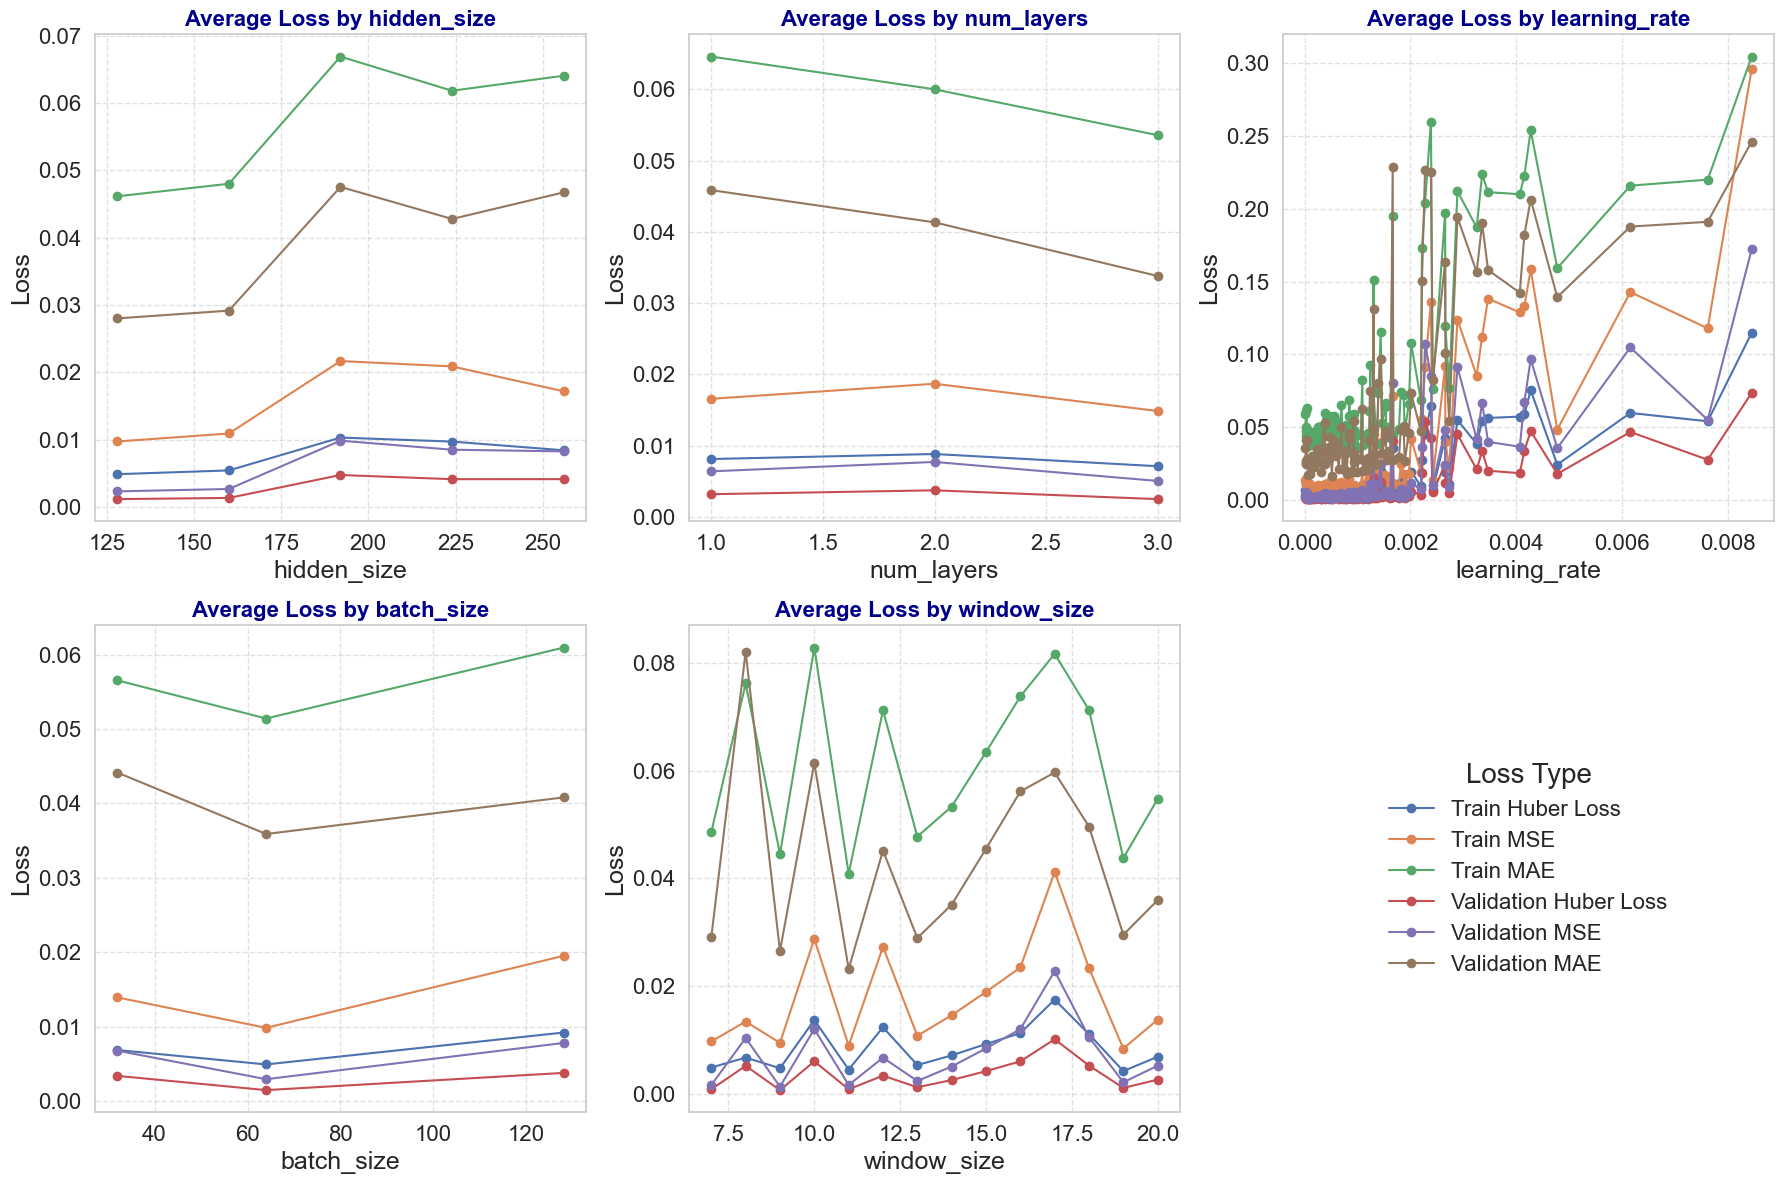

In [8]:
def plot_metrics_by_parameters(metrics_df, parameters, save_path):
    """
    Create a single figure with subplots for each parameter, showing average losses.

    Args:
        metrics_df (pd.DataFrame): DataFrame containing trial metrics and parameters.
        parameters (list): List of parameters to plot (e.g., ['hidden_size', 'num_layers', 'dropout']).
    """
    # Mapping loss types to more readable names
    loss_type_mapping = {
        "train_HuberLoss": "Train Huber Loss",
        "train_MSE": "Train MSE",
        "train_MAE": "Train MAE",
        "val_HuberLoss": "Validation Huber Loss",
        "val_MSE": "Validation MSE",
        "val_MAE": "Validation MAE"
    }

    num_params = len(parameters)
    ncols = 3  # Number of columns
    nrows = (num_params + ncols - 1) // ncols  # Dynamically calculate rows based on parameters
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 6 * nrows), sharex=False)

    # Flatten axes for easier iteration
    axes = axes.flatten()

    # Plot each parameter
    for i, (ax, parameter) in enumerate(zip(axes, parameters)):
        grouped = metrics_df.groupby(parameter).mean()  # Group by the parameter and calculate averages
        for loss, readable_name in loss_type_mapping.items():
            if loss in grouped.columns:
                ax.plot(grouped.index, grouped[loss], label=readable_name, marker='o', linestyle='-', linewidth=1.5)

        # Customize each subplot
        ax.set_xlabel(parameter, fontsize=18)
        ax.set_ylabel("Loss", fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.set_title(f"Average Loss by {parameter}", fontsize=16, weight='bold', color='darkblue')
        ax.grid(True, linestyle='--', alpha=0.6)

    # Remove unused subplots if parameters < nrows * ncols
    for j in range(len(parameters), len(axes)):
        if j == len(parameters):  # Use the first unused subplot for the legend
            handles, labels = ax.get_legend_handles_labels()
            axes[j].legend(
                handles, labels, loc="center", fontsize=16, title="Loss Type", title_fontsize=20, frameon=False
            )
            axes[j].set_axis_off()  # Turn off the axis for the legend plot
        else:
            fig.delaxes(axes[j])  # Remove any additional unused subplots

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

# Example: Plot average losses for all parameters in one figure
parameters_to_plot = ["hidden_size", "num_layers", "learning_rate", "batch_size", "window_size"]#, "dropout"]
plot_metrics_by_parameters(all_metrics_df, parameters_to_plot, f"{output_dir}/metrics_by_parameters_{model_name}.png")

### Predict the next 200 data points recursively

C:\Users\bar24\AppData\Local\Temp\ipykernel_4824\3508441007.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init_window = torch.tensor(val_X[0], dtype=torch.float32).to(device)


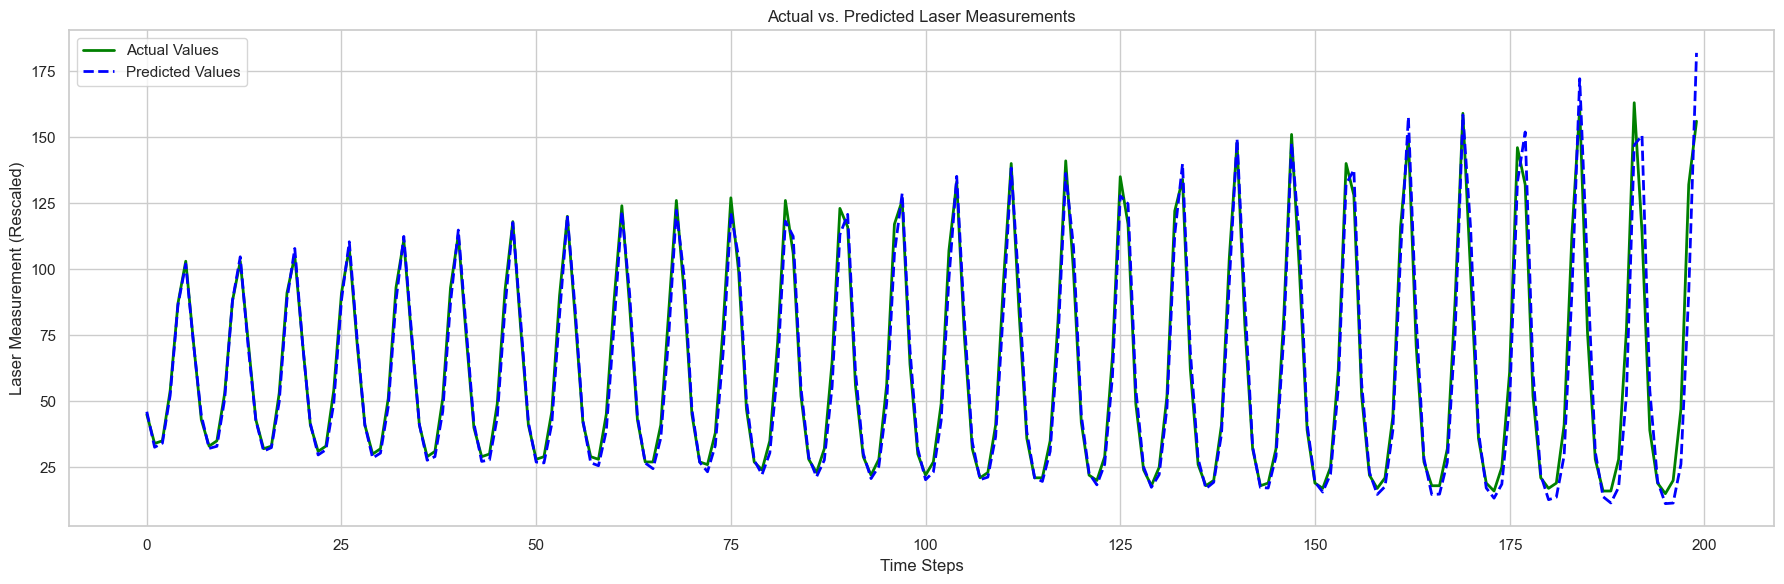

Metrics plot saved to ./Output/actual_vs_predicted_plot_RNN.png


In [9]:
def predict_and_inverse_transform(model, init_window, scaler, steps=200):
    """
    Perform recursive forecasting using the trained model and convert predictions back to the original range.

    Args:
        model: The trained Gated RNN model.
        init_window: The initial sequence window (tensor) in normalized form.
        scaler: The MinMaxScaler used for normalization.
        steps: Number of forecasting steps.

    Returns:
        np.array: Forecasted values in the original range.
    """
    model.eval()
    preds = []
    current_seq = init_window.clone().to(device)  # Ensure the initial window is on the correct device

    with torch.no_grad():
        for step in range(steps):
            # Forward pass
            input = current_seq.unsqueeze(0).contiguous()  # Add batch dimension
            pred = model(input)  # shape: (1, seq_len, forecast_steps)

            # Extract the first predicted value
            pred_value = pred.item()  # Extract the first step of the forecast
            preds.append(pred_value)

            # Update the sequence by appending the prediction and removing the oldest value
            next_value = torch.tensor([[pred_value]], dtype=torch.float32, device=device)
            current_seq = torch.cat((current_seq[1:], next_value), dim=0)

    # Convert predictions to numpy array
    preds = np.array(preds).reshape(-1, 1)

    # Inverse transform the predictions to the original range
    preds_original = scaler.inverse_transform(preds)

    return preds_original

def plot_signals(predictions_rescaled, actual_values, save_path):
    """
    Plot training and validation metrics after training and compare predictions with actual values.
    """
    plt.figure(figsize=(18, 6))

    # Plot Actual vs Predicted Values
    plt.plot(actual_values, label="Actual Values", color="green", linewidth=2)
    plt.plot(predictions_rescaled, label="Predicted Values", color="blue", linestyle="--", linewidth=2)
    plt.xlabel("Time Steps")
    plt.ylabel("Laser Measurement (Rescaled)")
    plt.title("Actual vs. Predicted Laser Measurements")
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"Metrics plot saved to {save_path}")
   
# Perform recursive forecasting to generate predictions
# Use the first sequence from the validation set as the initial window
init_window = torch.tensor(val_X[0], dtype=torch.float32).to(device)

# Predict and convert back to the original range
predicted_signal = predict_and_inverse_transform(best_model, init_window, scaler, steps=200)

# Compare with the actual values (also inverse transformed if needed)
actual_signal = scaler.inverse_transform(val_y[:len(predicted_signal)])

plot_signals(predicted_signal, actual_signal, f"{output_dir}/actual_vs_predicted_plot_{model_name}.png")

In [10]:
import torch.nn as nn

def evaluate_model_on_validation(best_model, val_loader):
    """
    Evaluate the best model on the validation dataset and calculate MSE and MAE using PyTorch loss functions.

    Args:
        best_model: The trained model.
        val_loader: The validation dataset (normalized).

    Returns:
        mse: Mean Squared Error.
        mae: Mean Absolute Error.
    """
    # Switch the model to evaluation mode
    best_model.eval()

    # Define PyTorch loss functions
    mse_criterion = nn.MSELoss()
    mae_criterion = nn.L1Loss()

    # Collect predictions and ground truth
    total_mse = 0.0
    total_mae = 0.0
    num_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            output = best_model(x_batch)

            # Calculate losses
            mse = mse_criterion(output, y_batch).item()
            mae = mae_criterion(output, y_batch).item()

            # Accumulate losses
            total_mse += mse * x_batch.size(0)
            total_mae += mae * x_batch.size(0)
            num_samples += x_batch.size(0)

    # Calculate average losses
    avg_mse = total_mse / num_samples
    avg_mae = total_mae / num_samples

    print(f"Validation MSE: {avg_mse}")
    print(f"Validation MAE: {avg_mae}")

    return avg_mse, avg_mae

# Evaluate the best model
mse, mae = evaluate_model_on_validation(best_model, val_loader)

Validation MSE: 3.484046161595851e-05
Validation MAE: 0.004708265703409276


### Load the trained model

In [ ]:
import json

def load_best_model():
    # Load the best hyperparameters
    with open(f"{model_dir}/best_hyperparameters_{model_name}.json", "r") as f:
        best_params = json.load(f)

    # Recreate the model with the best hyperparameters
    best_model = RNN(
        input_size=1,
        hidden_size=best_params['hidden_size'],
        num_stacked_layers=best_params['num_layers'],
        # dropout = best_params['dropout']
    ).to(device)

    # Load the saved model weights
    best_model.load_state_dict(torch.load(model_pth_path))
    best_model.eval()

    return best_model, best_params

best_model, best_params = load_best_model()
print("Best hyperparameters are:", best_params)